# ZAIRA

As this wave from memories flows in, the city soaks it up like a sponge and expands. A description of Zaira as it is today should contain all Zaira’s past. The city, however, does not tell its past, but contains it like the lines of a hand, written in the corners of the streets, the gratings of the windows, the banisters of the steps, the antennae of the lightning rods, the poles of the flags, every segment marked in turn with scratches, indentations, scrolls.

In [35]:
from __future__ import print_function

In [36]:
from IPython.display import Image

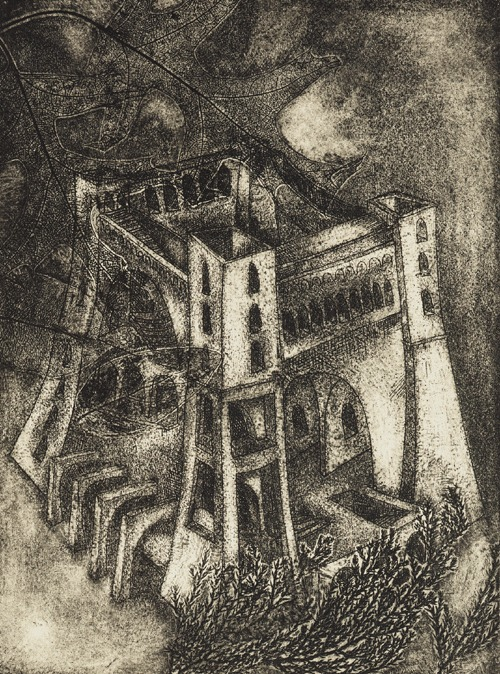

In [37]:
Image(filename='../Images/zaira.jpg') 

### ZAIRA

Objective: produces a file with the SiPM calibration parameters: noise, dark current, gain.

author: Jose A. Hernando
version: v0_00 

### Revision

In [38]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

20/10/2016   12:18:05


### Dependencies

In [39]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
import tables
import pandas as pd
import time

In [41]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [42]:
pp = %env PYTHONPATH
print(pp)
#from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


### DB  

In [43]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEWMC/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5in =tables.open_file(icdat+ifdat,'a')

In [44]:
# the sipm raw data table (all events)
sipmrd = h5in.root.sipmrd
# number of events, sipms, and w.f.length
nevts,nsipms,nshapes = sipmrd.shape[0],sipmrd.shape[1],sipmrd.shape[2]
print('number of events {}, number of sipms {}, wf length {}'.format(nevts,nsipms,nshapes))

# DB position of the (ordered) SiPMs 
sipmdb = h5in.root.Sensors.DataSiPM
print('DB for a SIPM index {}, {}'.format(0,sipmdb[0]))
h5index_of_sensorid = {sipmdb[i][0] : i for i in range(nsipms) }
i0 = sipmdb[0][0]
print('h5index of sensor id [{}]={}'.format(i0,h5index_of_sensorid[i0]))

def sipm_position_of_sensorid(senid):
    if (not h5index_of_sensorid.has_key(senid)): return [-200.,-200,0.]
    h5index = h5index_of_sensorid[senid]
    pos = sipmdb[h5index][2]
    return pos

senid=1000
pos = sipm_position_of_sensorid(senid)
print('position of sensor id {} = {}'.format(senid,pos))

number of events 1000, number of sipms 1789, wf length 1200
DB for a SIPM index 0, (1000, 1, [-235.0, 45.0, -10000.0], 1.0, 15.5)
h5index of sensor id [1000]=0
position of sensor id 1000 = [  -235.     45. -10000.]


### SiPM calibration data

In [45]:
indir = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/'
irun='2105'
infile = 'sipmCal_singlePulse_R'+irun

In [46]:
# input calibration data: dark current and led
import sipmcalib as sc
called = sc.CalData(indir+infile+'_led.txt')
caldark = sc.CalData(indir+infile+'_dark.txt')

loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/sipmCal_singlePulse_R2105_led.txt
number of SiPMs with data 1792
loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/sipmCal_singlePulse_R2105_dark.txt
number of SiPMs with data 1792


In [47]:
# create pdf file to put the figures
from matplotlib.backends.backend_pdf import PdfPages
pdf = None
#pdf = PdfPages('cal_R'+irun+'_figs.pdf')

In [48]:
def position_of_indexes(indexes):
    senids = map(sc.sensorid_of_index,indexes)
    pos = map(sipm_position_of_sensorid,senids)
    return np.array(pos)

In [49]:
# take the reference values
xbins = called.xbins
indexes = called.indexes
positions = position_of_indexes(indexes)

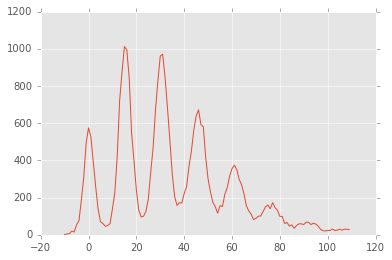

In [191]:
ucal = called
#ucal = called
ngauss = 7
id0 = indexes[10]
xs,ys = ucal.values_in_range(id0,(-10.,110.))
#id0 = indexes[1]
#ys = called.values[id0]
plt.plot(xs,ys)

In [203]:
# fit the histogram
#fun = sc.fun_poissongauss
fun = sc.fun_ngauss
print('fitting data...')

%timeit results, pss = sc.cal_fit_ngauss(ucal,[id0,],ngauss=ngauss)
#ps0 = np.array([10000.,0.,16.,1.,2.,2.])
#bounds = ((0.,-10.,10.,0.0,0.5,0.5),(20000.,10.,30.,2.,10.,10.))
#print(' bounds {}'.format(bounds))
#result = sc.cal_fit_(ps0,xs,ys,fun,bounds=bounds)
#print(' fit success {}'.format(result.success))
#pshat = result.x
pshat = pss[0]
if (results[0]):
    print(' fit results {}'.format(pshat[0:2]))
    print(' fit results {}'.format(pshat[2:]))

fitting data...
10 loops, best of 3: 19.9 ms per loop
 fit results [ -0.12602576  16.28249277]
 fit results [  1.40799002e+00   1.86958006e+00   2.28654383e+03   5.39958341e+03
   7.02557787e+03   6.02073631e+03   4.09953976e+03   2.32140096e+03
   1.18532880e+03]


4520 3549.63534584 1.27337023655


array([ 3549.63534584,   204.66155622,     6.42898339])

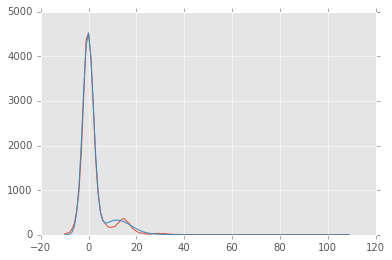

In [171]:
fys = fun(pshat,xs)
fig = plt.figure()
#scale = np.sum(ys)/np.sum(fys)
scale = np.max(ys)/np.max(fys)
print(np.max(ys),np.max(fys),scale)
plt.plot(xs,ys)
plt.plot(xs,scale*fys)
#plt.yscale('log')
if (pdf): pdf.savefig(fig)
#fun(pshat,[16.,])
#psa = np.array([0.,16.,2200.,5.,7000.,1.5])
fun(pshat,[0.,16.,32.])

In [93]:
if (pdf): pdf.close()

In [ ]:
print('WARNING!!!! RUNNING AHEAD!!!')

In [204]:
%timeit oks,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)

fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting 

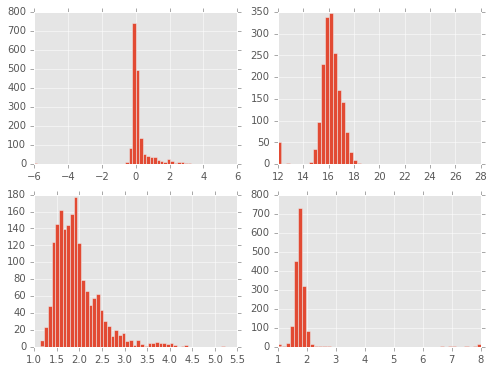

In [184]:
x0s = map(lambda x: x[0],pss)
gs = map(lambda x: x[1],pss)
nois = map(lambda x: x[2],pss)
nois1 = map(lambda x: x[3],pss)
nbins=50
fig, axes = plt.subplots(2,2,figsize=(8,6))
plt.subplot(2,2,1)
cc = plt.hist(x0s,nbins)
plt.subplot(2,2,2)
cc = plt.hist(gs,nbins)
plt.subplot(2,2,3)
cc = plt.hist(nois,nbins)
plt.subplot(2,2,4)
cc = plt.hist(nois1,nbins)
plt.show()
fig.savefig('fit_text.pdf')

In [190]:
fun = sc.fun_ngauss
ffun = sc.ffun_ngauss
ps = np.array([0.,15.,2.,2.,1000.,100.,10.,1.])
xs = np.linspace(-20.,140.,1000)
%timeit ys = fun(ps,xs)
%timeit ys = ffun(ps,xs)

100 loops, best of 3: 11.7 ms per loop
10000 loops, best of 3: 111 µs per loop


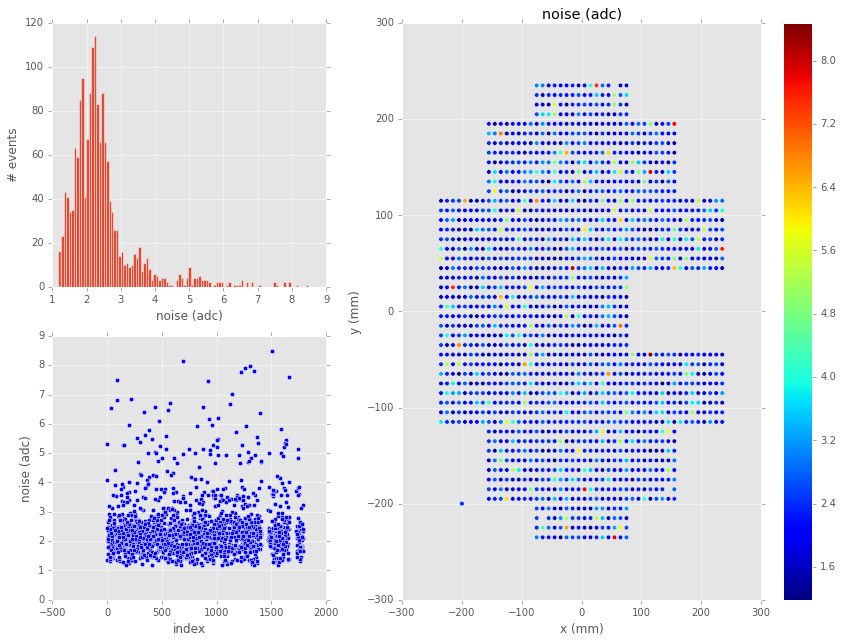

In [383]:
fig = sc.polo_pars(indexes,nois,positions,label='noise (adc)')
pdf.savefig(fig)

In [384]:
darkc = sc.cal_dark_current(caldark,indexes)

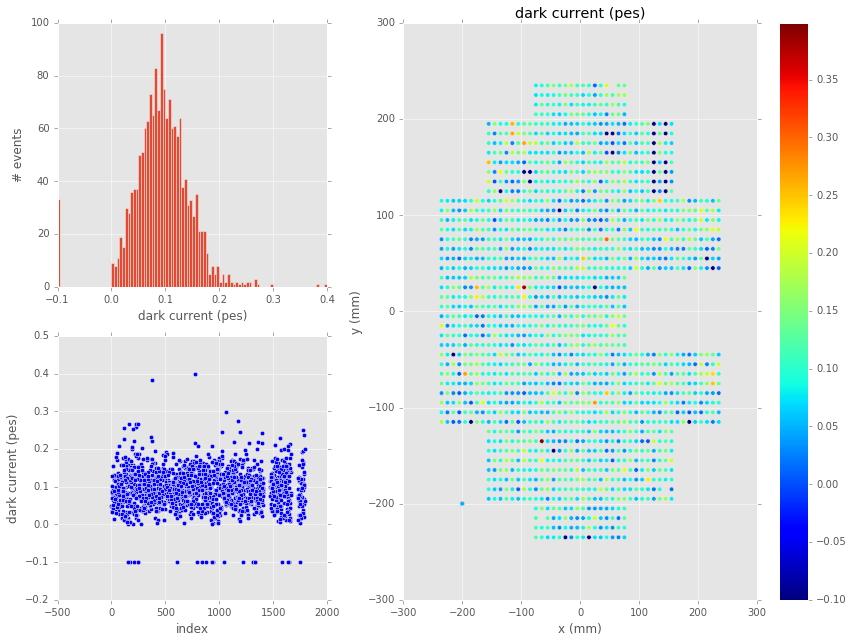

In [385]:
fig = sc.polo_pars(indexes,darkc,positions,label='dark current (pes)')
pdf.savefig(fig)

In [386]:
gains = sc.cal_gain(called,indexes)

fitting...
fitting...
fitting...
fitting...


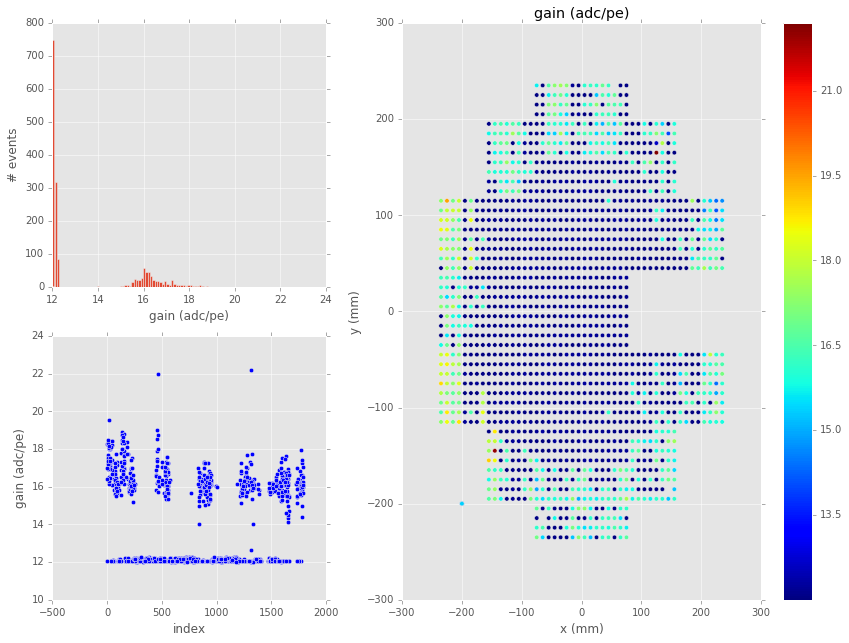

In [387]:
fig = sc.polo_pars(indexes,gains,positions,label='gain (adc/pe)')
pdf.savefig(fig)

In [388]:
sigs = sc.cal_led_signal(caldark,called,indexes)
calsig = sc.cal_caldata(xbins,sigs,indexes)

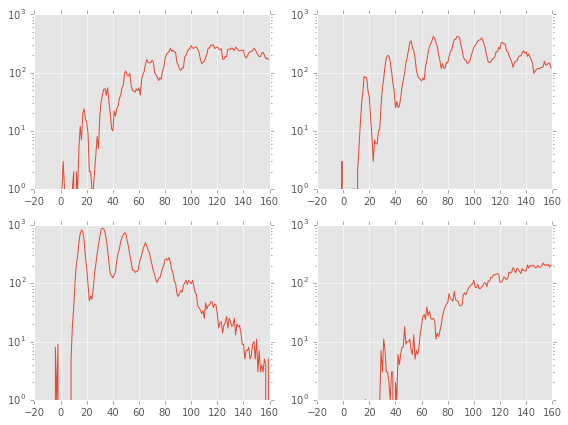

In [389]:
fig = sc.polo_cal(calsig,indexes[:4],xrange=(-10.,160.))
pdf.savefig(fig)

In [390]:
leds = sc.cal_led_pes(caldark,called)

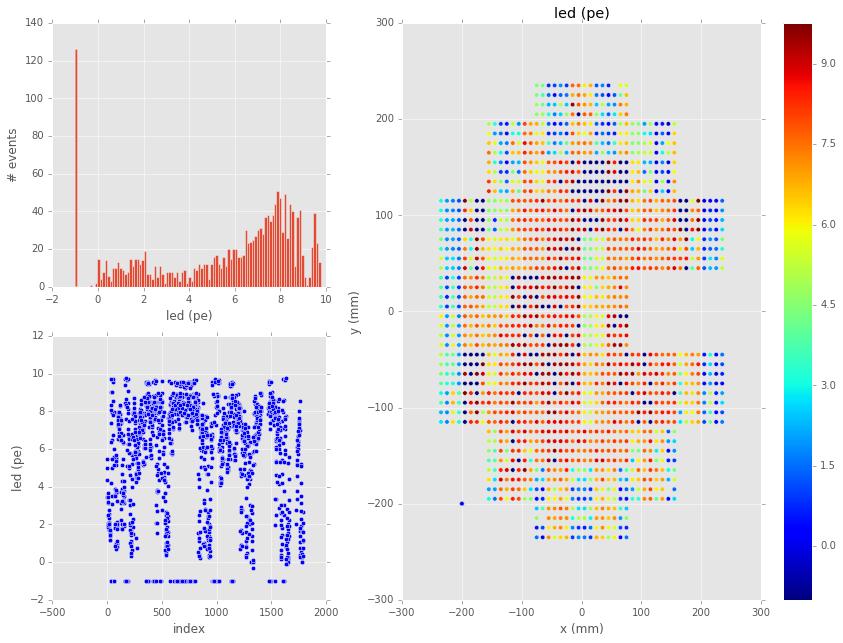

In [391]:
fig = sc.polo_pars(indexes,leds,positions,label='led (pe)')
pdf.savefig(fig)

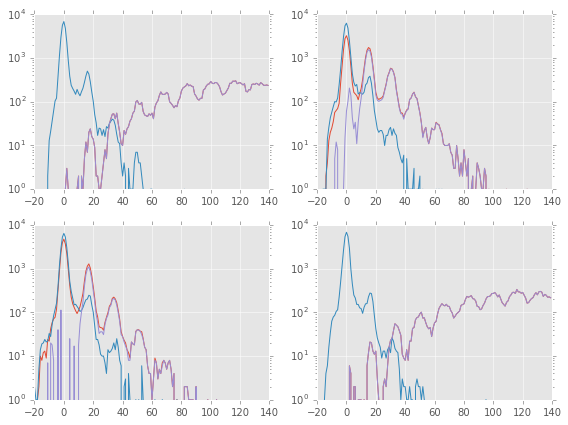

In [392]:
#select very low values of leds
hled = 0.8
zz = zip(called.indexes,leds)
zz1 = filter(lambda z: z[1]<hled,zz)
indexes1 = map(lambda z:z[0],zz1)
fig = sc.polo_cals([called,caldark,calsig],indexes1[:4],xrange=(-20.,140.))
pdf.savefig(fig)

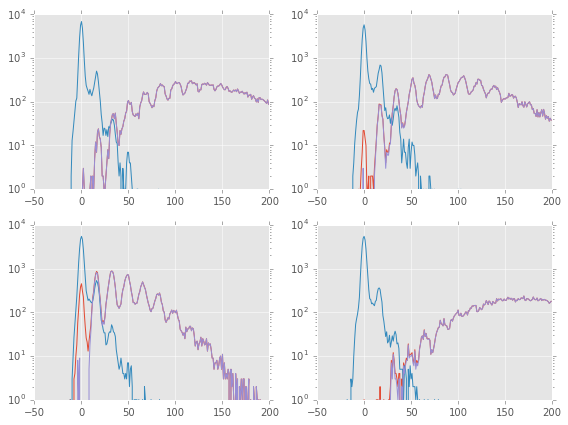

In [393]:
# select SiPMs with high led values
hled = 3.
zz = zip(called.indexes,pes)
zz2 = filter(lambda z: z[1]>hled,zz)
indexes2 = map(lambda z:z[0],zz2)
fig = sc.polo_cals([called,caldark,calsig],indexes2[:4],xrange=(-20,200.))
pdf.savefig(fig)

In [394]:
pdf.close()

In [395]:
sc.cal_save('cal_R'+irun+'.txt',indexes,nois,darkc,gains,leds)

That's all folks!